In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats

warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv("data_train.csv")
df.head()

,id,Tahun,Bulan,Suhu,Lembab,BTA+
0,1,2007.0,Januari,NaN,77.903226,49
1,2,2007.0,Februari,NaN,81.750000,54
2,3,NaN,Maret,NaN,NaN,60
3,4,NaN,April,NaN,NaN,75
4,5,NaN,Mei,NaN,NaN,81
...,...,...,...,...,...,...
80,81,2013.0,September,NaN,NaN,96
81,82,2013.0,Oktober,NaN,70.709677,81
82,83,2013.0,November,23.996667,NaN,78
83,84,2013.0,Desember,NaN,85.870968,75


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      85 non-null     int64  
 1   Tahun   70 non-null     float64
 2   Bulan   76 non-null     object 
 3   Suhu    27 non-null     float64
 4   Lembab  16 non-null     float64
 5   BTA+    85 non-null     int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 4.1+ KB


In [4]:
df.describe()

,id,Tahun,Suhu,Lembab,BTA+
count,85.000000,70.000000,27.000000,16.000000,85.000000
mean,43.000000,2010.271429,23.325671,75.743985,79.658824
std,24.681302,2.028217,0.946959,5.559270,18.131499
min,1.000000,2007.000000,21.658065,68.870968,40.000000
25%,22.000000,2009.000000,22.645860,71.096774,65.000000
50%,43.000000,2010.000000,23.548387,74.063978,81.000000
75%,64.000000,2012.000000,23.964405,79.896505,93.000000
max,85.000000,2014.000000,24.910000,85.870968,117.000000


In [6]:
df['BTA+'].isnull().sum()

0

<Axes: >

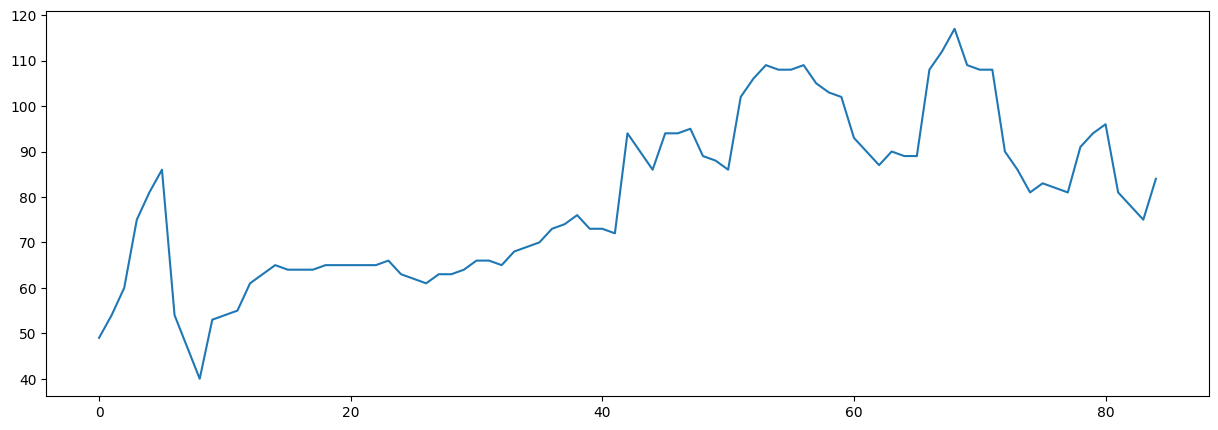

In [7]:
df['BTA+'].plot(figsize=(15,5))

In [9]:
new_df = df[['Tahun', 'Bulan', 'BTA+']].copy()
new_df.info()
print(new_df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tahun   70 non-null     float64
 1   Bulan   76 non-null     object 
 2   BTA+    85 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ KB
Tahun    float64
Bulan     object
BTA+       int64
dtype: object


In [10]:
# Step 1: Forward-fill missing 'Tahun' and 'Bulan' values
new_df['Tahun'].ffill(inplace=True)  # Forward-fill 'Tahun'
new_df['Bulan'].ffill(inplace=True)  # Forward-fill 'Bulan'

# Step 2: Convert 'Tahun' to integers
new_df['Tahun'] = new_df['Tahun'].astype(int)

# Step 3: Create a mapping from Indonesian month names to month numbers
month_mapping = {
    'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4, 'Mei': 5,
    'Juni': 6, 'Juli': 7, 'Agustus': 8, 'September': 9, 'Oktober': 10,
    'November': 11, 'Desember': 12
}

# Step 4: Map 'Bulan' to their corresponding month numbers
new_df['Bulan'] = new_df['Bulan'].map(month_mapping)

# Step 5: Create the 'date' column by combining 'Tahun' and 'Bulan'
new_df['date'] = pd.to_datetime(new_df['Tahun'].astype(str) + '-' + new_df['Bulan'].astype(str), format='%Y-%m')

# Step 6: Drop the original 'Tahun' and 'Bulan' columns, keeping only 'date' and 'BTA+'
new_df = new_df[['date', 'BTA+']]

In [11]:
new_df.head()

,date,BTA+
0,2007-01-01,49
1,2007-02-01,54
2,2007-03-01,60
3,2007-04-01,75
4,2007-05-01,81


In [13]:
new_df['date'].isnull().sum()

0

In [14]:
new_df['BTA+'] = new_df['BTA+'].astype(float)
new_df.head()

,date,BTA+
0,2007-01-01,49.0
1,2007-02-01,54.0
2,2007-03-01,60.0
3,2007-04-01,75.0
4,2007-05-01,81.0


In [15]:
print(new_df.duplicated().sum())
new_df.drop_duplicates(subset='date', inplace=True)
new_df.reset_index(drop=True, inplace=True)
new_df.sort_values(by='date')

1


,date,BTA+
0,2007-01-01,49.0
1,2007-02-01,54.0
2,2007-03-01,60.0
3,2007-04-01,75.0
4,2007-05-01,81.0
...,...,...
72,2013-09-01,96.0
73,2013-10-01,81.0
74,2013-11-01,78.0
75,2013-12-01,75.0


In [16]:
print(new_df['BTA+'].isnull().sum()/df.shape[0]*100)
median_value = new_df['BTA+'].median()
print()
new_df.fillna(median_value, inplace=True)
print(new_df['BTA+'].isnull().sum())

0.0

0


In [17]:
new_df["zscore_val"] = stats.zscore(new_df['BTA+'])

threshold = 3
outliers = new_df[(new_df['zscore_val'] > threshold) | (new_df['zscore_val'] < -threshold)]
new_df.loc[outliers.index, 'BTA+'] = median_value

new_df.drop(columns=['zscore_val'], inplace=True)

In [18]:
new_df['date'] = pd.to_datetime(new_df['date'])
new_df.set_index('date', inplace=True)

In [19]:
new_df.sort_index(inplace=True)

<Axes: xlabel='date'>

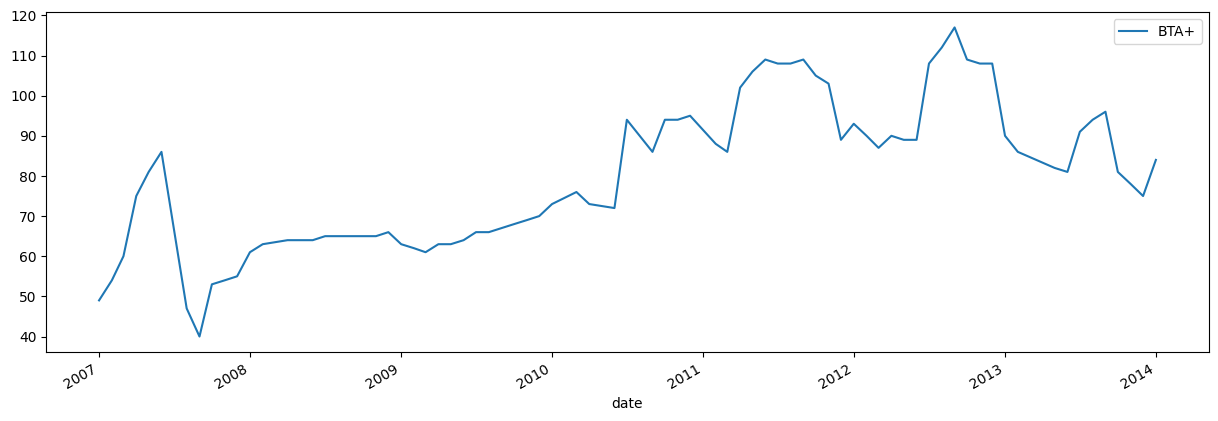

In [20]:
new_df.plot(figsize=(15,5))

In [21]:
new_df.describe()

,BTA+
count,77.000000
mean,80.181818
std,18.466704
min,40.000000
25%,65.000000
50%,81.000000
75%,94.000000
max,117.000000


# Exploratory Data Analysis (EDA)

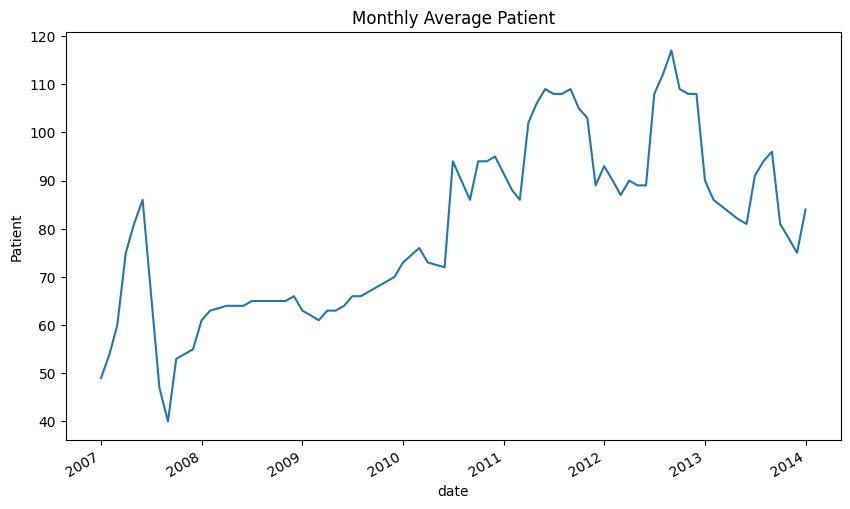

In [23]:
# Menghitung rata-rata suhu bulanan
monthly_avg = new_df['BTA+']

# Visualisasi rata-rata bulanan
monthly_avg.plot(figsize=(10, 6), title='Monthly Average Patient')
plt.ylabel('Patient')
plt.show()


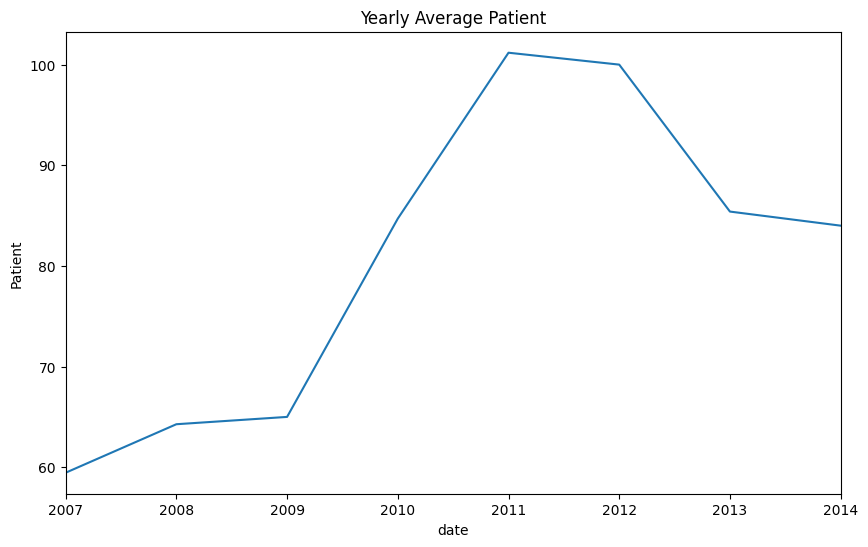

In [24]:
# Menghitung rata-rata suhu tahunan
yearly_avg = new_df['BTA+'].resample('Y').mean()

# Visualisasi rata-rata tahunan
yearly_avg.plot(figsize=(10, 6), title='Yearly Average Patient')
plt.ylabel('Patient')
plt.show()


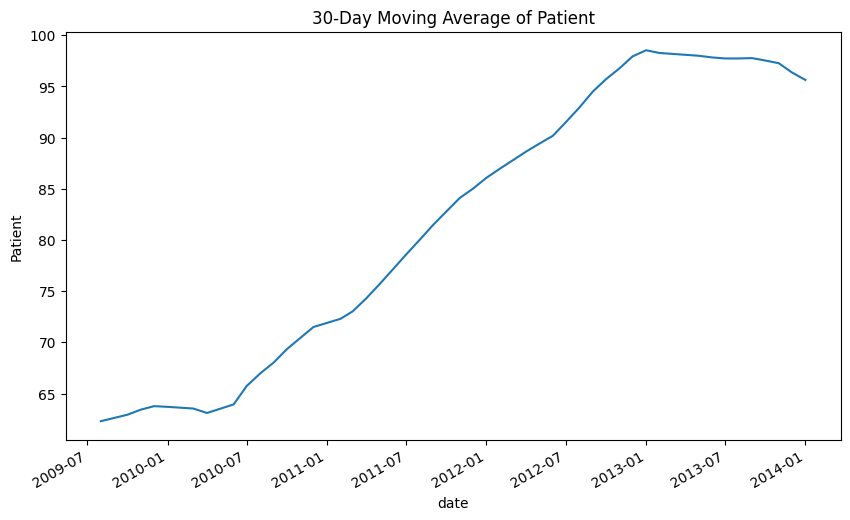

In [25]:
# Moving average dengan window 30 hari
new_df['BTA+'].rolling(window=30).mean().plot(figsize=(10, 6), title='30-Day Moving Average of Patient')
plt.ylabel('Patient')
plt.show()

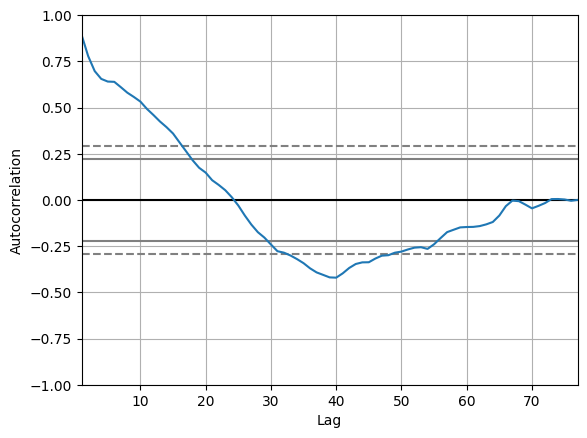

In [26]:
from pandas.plotting import autocorrelation_plot

# Plot autokorelasi
autocorrelation_plot(new_df['BTA+'])
plt.show()

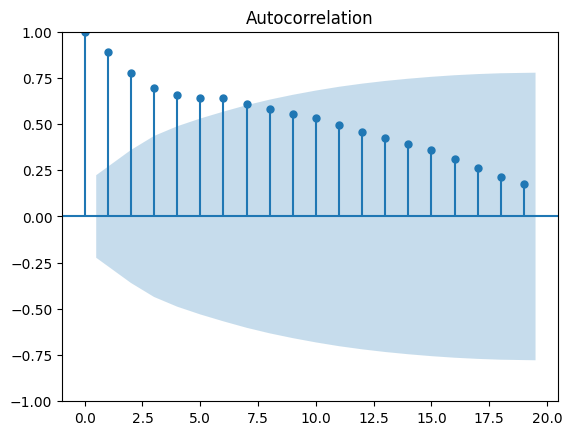

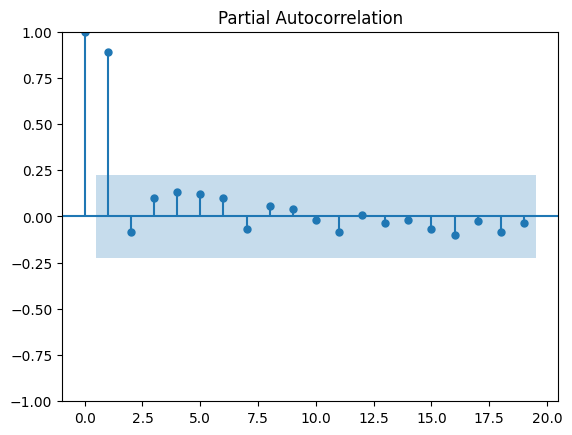

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF dan PACF
plot_acf(new_df['BTA+'])
plot_pacf(new_df['BTA+'])
plt.show()

In [28]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(df):
    result = adfuller(df, autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used', 'Critical Values']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))

In [29]:
adfuller_test(new_df['BTA+'])

ADF Test Statistic : -2.2712230389139254
p-value : 0.18141711831390922
#Lags Used : 0
Number of Observations Used : 76
Critical Values : {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}


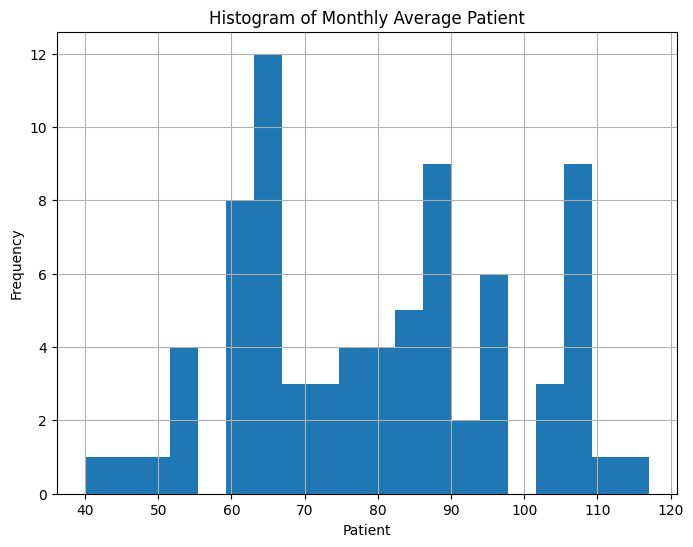

In [30]:
# Histogram dari data Tavg
new_df['BTA+'].hist(bins=20, figsize=(8, 6))
plt.title('Histogram of Monthly Average Patient')
plt.xlabel('Patient')
plt.ylabel('Frequency')
plt.show()